### Forecasting BTC-USD Realized Volatility 

Volatility can either be historical or implied; both are usually expressed on an annualized basis in percentage terms. 

- **Historical Volatility** (HV) or **Realized Volatility** is the actual volatility demonstrated by the underlying over a period of time, such as the past month or year. 
- **Implied volatility** (IV), on the other hand, is the level of volatility of the underlying that is implied by the current option price.

(source: https://www.investopedia.com/articles/investing/021716/strategies-trading-volatility-options-nflx.asp)

The fundamental equation in option trading is:

$P/L = Vega|\sigma_{implied} - \sigma_{realized}|$

in which Vega measures an option’s price sensitivity, or the price change of an option for every 1% change in volatility of the underlying.

If we can identify situations where the above volatility mismatch occurs, there's potential Profit or Loss that can be captured.

(source: **Positional Option Trading: An Advanced Guide** by Euan Sinclair)

The purpose of this project is to forecast one variable of the above equation: the **realized volatility** based on historical/past data using time series analysis. The basic idea we want to describe here is the realized volatility of BTC-USD (returns or log returns of close price of BTC-USD on time step day `t` as estimated at the end of the previous day `t-1`).

“Volatility does **not** measure the direction of price changes, merely their dispersion. This is because when calculating standard deviation (or variance), all differences are squared, so that negative and positive differences are combined into one quantity. Two instruments with different volatilities may have the same expected return, but the instrument with higher volatility will have larger swings in values over a given period of time.”
(source: Wikipedia)

### Challenges

Although the forecasting and modeling of volatility has been the focus of many empirical studies and theoretical investigations in academia, forecasting volatility accurately remains a crucial challenge for scholars. In addition, Crypto options trading is relatively new, there has not been too much research on the topic. There would be certain nuances to crypto that need to be mindful of, and accounted for in this project.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
from scipy import stats

%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
!pip install arch

     |████████████████████████████████| 875 kB 12.6 MB/s 
     |████████████████████████████████| 9.5 MB 74.8 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [4]:
!pip3 install yfinance

     |████████████████████████████████| 6.3 MB 18.2 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23919 sha256=e99049986c0682917cc14cb49de07acc6589099fb65c97bc6bd96c08821e11fc
  Stored in directory: /root/.cache/pip/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [5]:
import yfinance as yf

In [6]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [250]:
from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error as mse, r2_score 

In [8]:
start = datetime(2014, 1, 1)
end = datetime.today()

tckr = 'BTC-USD'

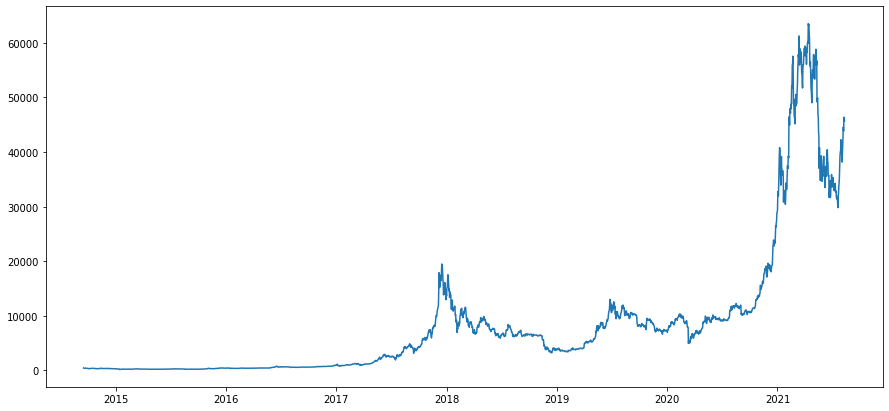

In [9]:
ticker = yf.Ticker(tckr)
ticker_historical = ticker.history(start=start, 
                                   end=end, 
                                   interval="1d")

plt.figure(figsize=(15,7))
plt.plot(ticker_historical.Close);

In [10]:
ticker_historical.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800,0,0
2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200,0,0
2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700,0,0
2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600,0,0
2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100,0,0


Often times, volatility is calculated as the standard deviation of price returns, which is the dollar change in price as a percentage of previous day's price.

In [11]:
# CALCULATE PRICE RETURNS AS DAILY PERCENTAGE CHANGE USING pct_change()
returns = 100 * ticker_historical.Close.pct_change().dropna()

Further research indicates that for practicality purposes it's preferable to use the log returns especially in modeling, because it helps eliminate non-stationary properties of time series data, and makes it more stable. On top of that, it reduces computational cost. 


LOG RETURNS FORMULA:

$r_{t1, t2} = log(P_{t2} / P_{t1})$

There's another advantage to log returns, which is that they're additive across time: $r_{t1, t2} + r_{t2, t3} = r_{t1, t3}$


In [12]:
# CALCULATE LOG RETURNS BASED ON ABOVE FORMULA
log_returns = np.log(ticker_historical.Close/ticker_historical.Close.shift(1)).dropna()

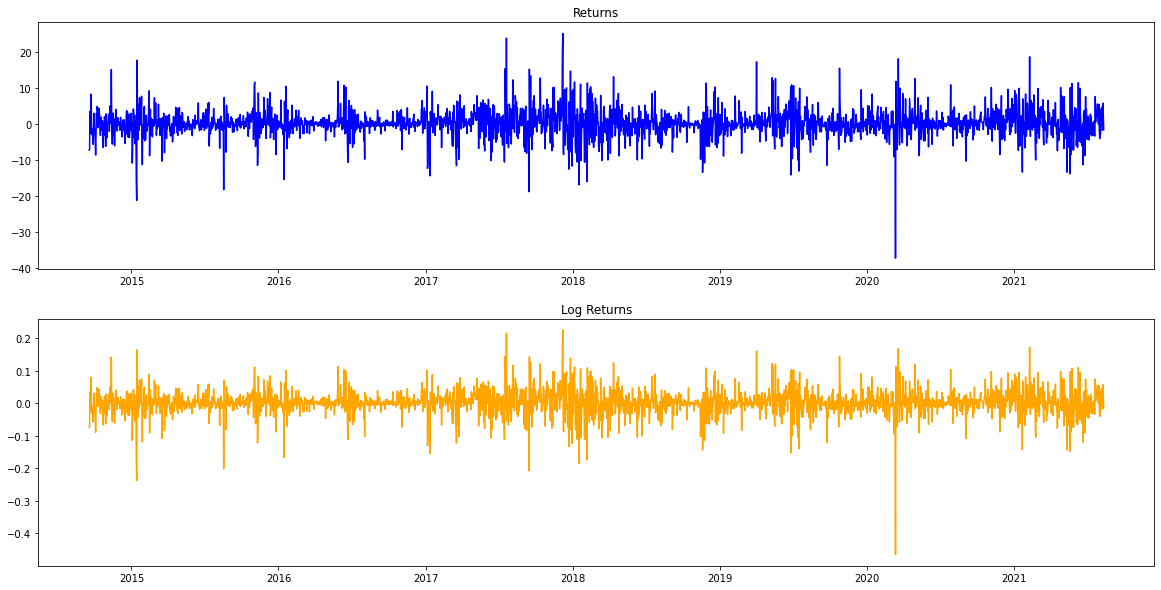

In [13]:
# VISUALIZE RETURNS VS. LOG RETURNS
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(20,10))

ax1.plot(returns, color='blue')
ax1.set_title('Returns')

ax2.plot(log_returns, color='orange')
ax2.set_title('Log Returns')

fig.show();

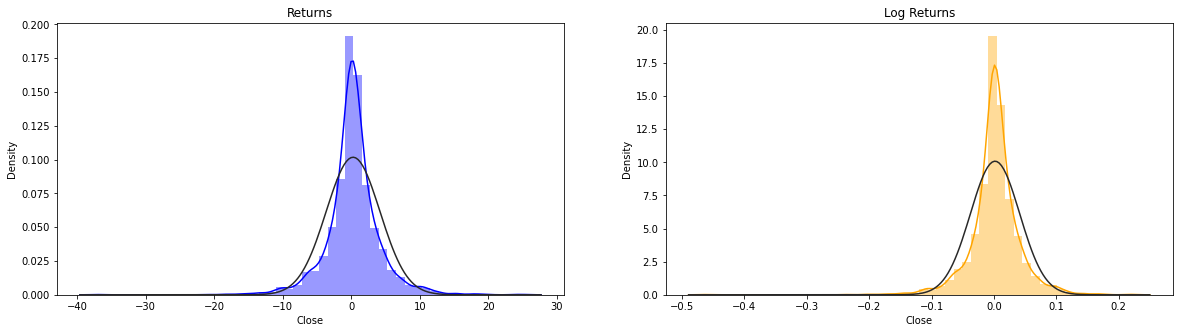

In [14]:
# PLOT DISTRIBUTION PLOTS OF RETURNS & LOG RETURNS
# AND VISUALLY COMPARE THEM WITH THE STANDARD NORMAL DISTRIBUTION
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
sns.distplot(returns, norm_hist=True, fit=stats.norm, color='blue',
             bins=50, ax=ax1)
ax1.set_title('Returns')

sns.distplot(log_returns, norm_hist=True, fit=stats.norm, color='orange',
             bins=50, ax=ax2)
ax2.set_title('Log Returns')

fig.show();

In [15]:
returns.describe()

count    2515.000000
mean        0.260924
std         3.922149
min       -37.169539
25%        -1.277171
50%         0.202169
75%         1.826197
max        25.247169
Name: Close, dtype: float64

In [16]:
log_returns.describe()

count    2515.000000
mean        0.001831
std         0.039565
min        -0.464730
25%        -0.012854
50%         0.002020
75%         0.018097
max         0.225119
Name: Close, dtype: float64

Both Returns & Log Returns show some:
- slight negative skewness
- positive kurtosis (leptokurtic) - higher peak with thick tails than the standard normal distribution.

For this specific project, the volatility would be calculated as the standard deviation of daily log returns, or the square root of the sum of squares of daily log returns:

$\sigma_{t} = \sqrt{\sum_{t} r_{t-1, t}^2}$


In [17]:
# CREATE A FUNCTION THAT CALCULATE REALIZED VOLATILITY
def realized_volatility(series_log_return):
    """
    Get realized volatility which is calculated as the square root
    of sum of squares of log returns
    """
    return np.sqrt(np.sum(series_log_return**2))

In [39]:
log_returns.apply(realized_volatility)

Date
2014-09-18    0.074643
2014-09-19    0.103989
2014-09-20    0.109756
2014-09-21    0.112560
2014-09-22    0.112867
                ...   
2021-08-06    1.984555
2021-08-07    1.984954
2021-08-08    1.985028
2021-08-09    1.985845
2021-08-11    1.985897
Name: Close, Length: 2515, dtype: float64

### Stationarity Checking

In [41]:
from statsmodels.tsa.stattools import adfuller

In [43]:
adfuller_results = adfuller(log_returns)

print(f'ADF Statistic: {adfuller_results[0]}')
print(f'p-value: {adfuller_results[1]}')
print('Critical Values:')
for key, value in adfuller_results[4].items():
    print(f'{key}: {value:.4f}')

ADF Statistic: -15.050535687465157
p-value: 9.307891898361368e-28
Critical Values:
1%: -3.4330
5%: -2.8627
10%: -2.5674


Using a significant level alpha of 0.05, `p-value` is significantly smaller than alpha, which means the Null Hypothesis can be rejected. 

--> Log returns is not dependent on time/trend

In [45]:
ticker_historical.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2014-09-17 to 2021-08-11
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          2516 non-null   float64
 1   High          2516 non-null   float64
 2   Low           2516 non-null   float64
 3   Close         2516 non-null   float64
 4   Volume        2516 non-null   int64  
 5   Dividends     2516 non-null   int64  
 6   Stock Splits  2516 non-null   int64  
dtypes: float64(4), int64(3)
memory usage: 237.2 KB


### Train-Validation-Test Split

I would apply the 80/20 rule: 
- train on 80% of the dataset
- and validate using the remaining 20%
- the remaining 16 days would be used for testing

There're a total of 2516 datapoints in this dataset which covers a period of almost 7 years from September 2014 until today (August 2021). Since cryptocurrencies are not traded on a regulated exchange, the Bitcoin market is open 24/7, 1 year covers a whole 365 trading days instead of 252 days a year like with other stocks and commodities.

I am going to split the data into 3 parts:
- training: from index 0 to 1999 (inclusive)
- validation: from index 2000 to 2500 (inclusive)
- test - the most recent days

In [142]:
split_time_1 = 2000
split_time_2 = 2500

train_idx = log_returns.index[:split_time_1]
val_idx = log_returns.index[split_time_1:split_time_2]
test_idx = log_returns.index[split_time_2:]

In [143]:
ts_train = log_returns[train_idx]
ts_val = log_returns[val_idx]
ts_test = log_returns[test_idx]

In [144]:
# GET VOLATILITY SERIES vols
vols = log_returns.apply(realized_volatility)

# SPLIT vols INTO 3 PARTS
vol_train = vols[train_idx]
vol_val = vols[val_idx]
vol_test = vols[test_idx]

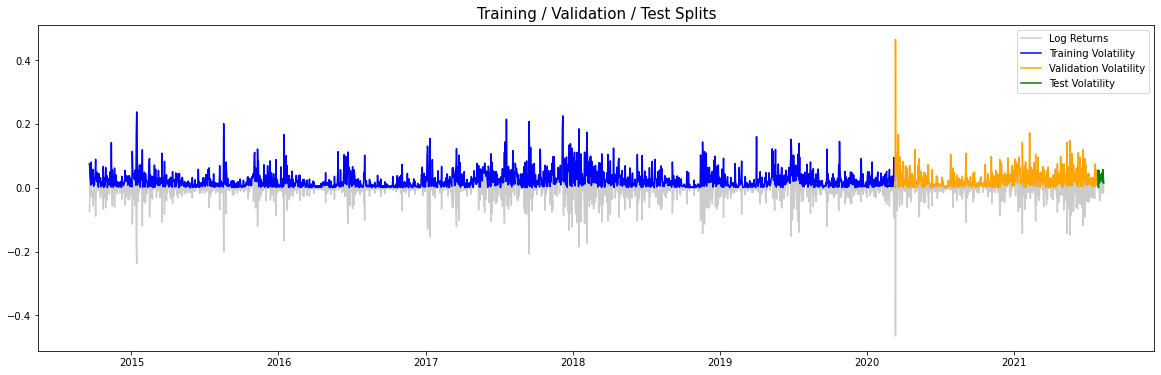

In [56]:
plt.figure(figsize=(20,6))

plt.plot(log_returns, color='gray', label='Log Returns', alpha=0.4)

plt.plot(vol_train, color='blue', label='Training Volatility')
plt.plot(vol_val, color='orange', label='Validation Volatility')
plt.plot(vol_test, color='green', label='Test Volatility')

plt.plot()
plt.title('Training / Validation / Test Splits', fontsize=15)
plt.legend()
plt.show();

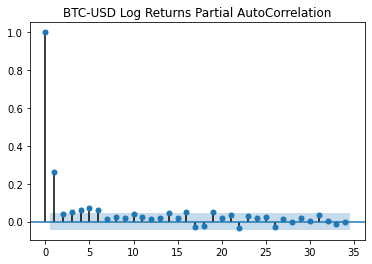

In [145]:
plot_pacf(ts_train**2, 
          title=f'{tckr.upper()} Log Returns Partial AutoCorrelation');

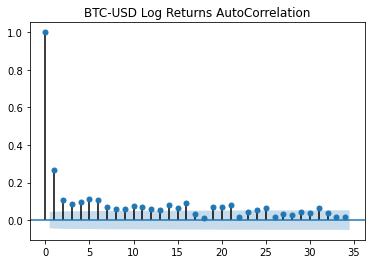

In [146]:
plot_acf(ts_train**2, 
          title=f'{tckr.upper()} Log Returns AutoCorrelation');

## Baseline Model

This would be a very simple model that only outputs the average volatility of the whole training data as predictions.

In [59]:
# CALCULATE THE MEAN OF TRAINING DATA
mean_train_vol = vol_train.mean()
mean_train_vol

0.02500113067367762

In [60]:
# CREATE SERIES OF PREDICTIONS FOR BASELINE MODEL ON VALIDATION SET
baseline_preds = np.ones(len(ts_val)) * mean_train_vol
baseline_preds = pd.Series(baseline_preds, index=ts_val.index)

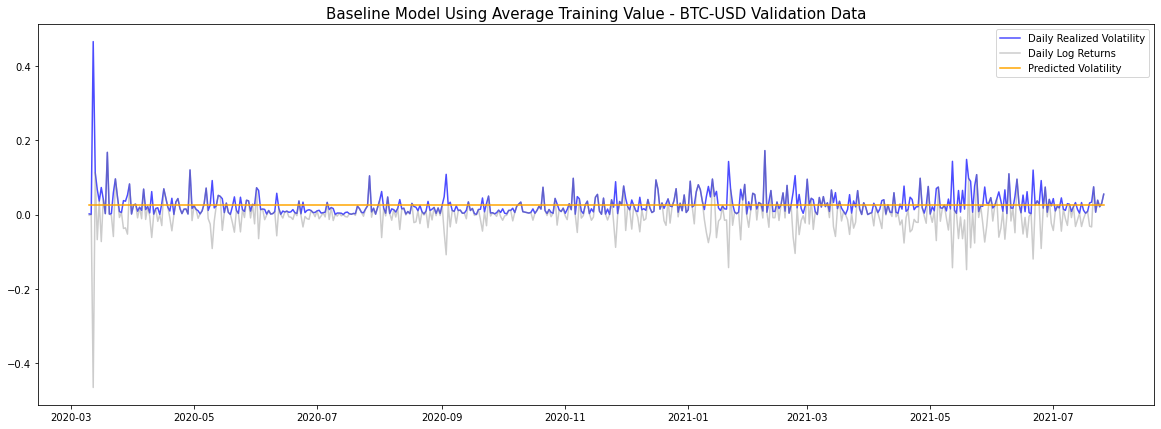

In [61]:
plt.figure(figsize=(20,7))
plt.plot(vol_val, color='blue', label='Daily Realized Volatility', alpha=0.7)
plt.plot(ts_val, color='gray', alpha=0.4, label='Daily Log Returns')
plt.plot(baseline_preds, color='orange', label='Predicted Volatility')

plt.title(f'Baseline Model Using Average Training Value - {tckr} Validation Data', fontsize=15)
plt.legend();

In [62]:
def RMSE(y_true, y_pred):
    """
    Compute Root Mean Squared Error between 2 arrays
    """
    output = np.sqrt(mse(y_true, y_pred))
    return output

In [64]:
def RMSPE(y_true, y_pred):
    """
    Compute Root Mean Squared Percentage Error between 2 arrays
    """
    output = np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))
    return output

In [63]:
RMSE(vol_val, baseline_preds)

0.03444040231025839

In [65]:
RMSPE(vol_val, baseline_preds)

65.51084629776182

### Naive Random Walk Forecasting

A commonly known fact about volatility is that it tends to be autocorrelated. This property can be used to implement a naive model that just "predicts" realized volatility by using whatever the realized volatility was at the immediate previous time step.

In [147]:
random_walk_preds = vols.shift(1).dropna()[val_idx]

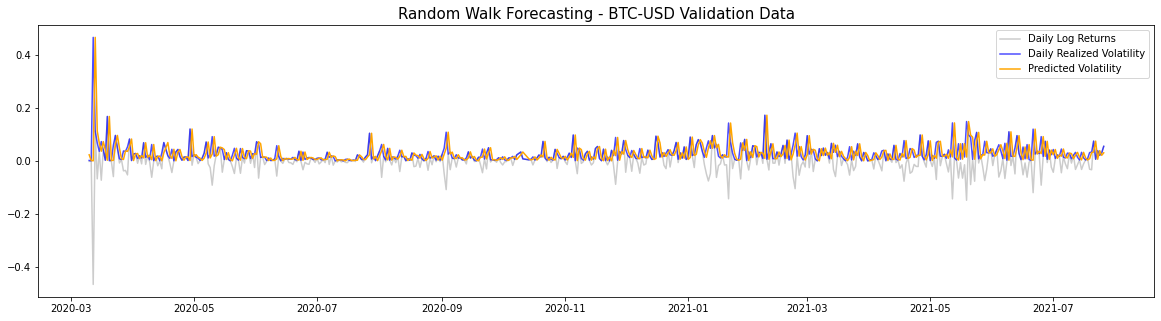

In [148]:
plt.figure(figsize=(20,5))
plt.plot(ts_val, color='gray', alpha=0.4, label='Daily Log Returns')
plt.plot(vol_val, color='blue', alpha=0.7,
         label='Daily Realized Volatility')
plt.plot(random_walk_preds, color='orange', label='Predicted Volatility')

plt.title(f'Random Walk Forecasting - {tckr} Validation Data', fontsize=15)
plt.legend();

In [149]:
RMSE(vol_val, random_walk_preds)

0.04671577639538798

In [150]:
RMSPE(vol_val, random_walk_preds)

48.9870165969153

### GARCH Model

GARCH Model is the traditional econometric approach to volatility prediction of financial time series.

GARCH(1,1) Model Equation:


$\sigma^2_t = \omega + \alpha\epsilon^{2}_{(t-1)} + \beta\sigma^{2}_{(t-1)}$

In [72]:
from arch import arch_model

In [190]:
gm_1 = arch_model(ts_train, vol='GARCH', p=1, q=1,
                  mean='Zero', dist='normal')
result_1 = gm_1.fit(disp='off')
print()
print(result_1.summary())


                       Zero Mean - GARCH Model Results                        
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                3899.36
Distribution:                  Normal   AIC:                          -7792.73
Method:            Maximum Likelihood   BIC:                          -7775.92
                                        No. Observations:                 2000
Date:                Wed, Aug 11 2021   Df Residuals:                     2000
Time:                        03:28:26   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      9.7480e-05  4.028e-05      2.420  1.553e-02 [1

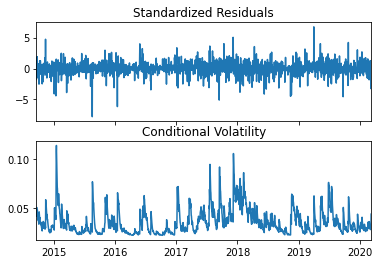

In [191]:
result_1.plot()
plt.show();

#### Making Predictions

In [192]:
# ROLLING FORECAST
# INITIALIZING rolling_forecasts VALUES LIST
rolling_forecasts = []

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(ts_val)):
    # GET THE DATA AT ALL PREVIOUS TIME STEPS
    idx = val_idx[i]
    train = log_returns[:idx]

    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(train, vol='GARCH', p=1, q=1,
                       mean='Zero', dist='normal')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION
    pred = (model_fit.forecast(horizon=1, reindex=False).variance.values[0][0])**.5

    # APPEND TO rolling_forecasts LIST
    rolling_forecasts.append(pred)

In [193]:
rolling_predictions_1 = pd.Series(rolling_forecasts, index=ts_val.index)

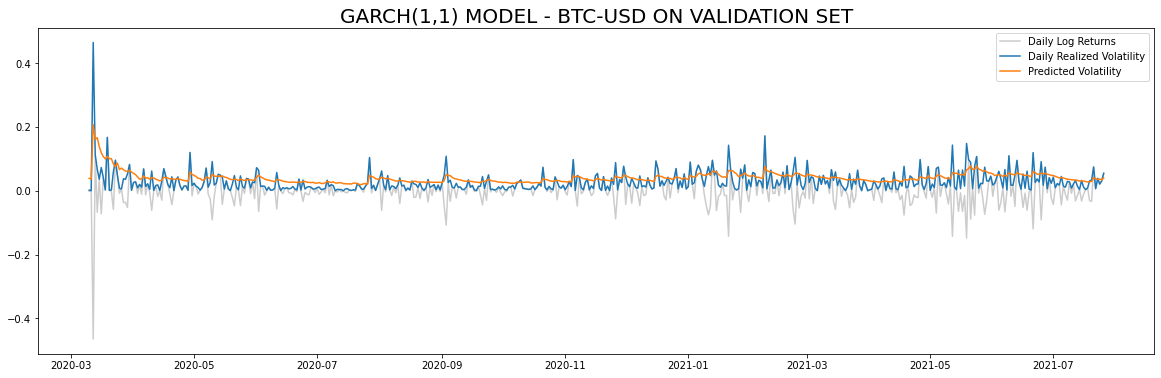

In [194]:
plt.figure(figsize=(20,6))
plt.plot(ts_val, color='gray', alpha=0.4, label='Daily Log Returns')

plt.plot(vol_val, label='Daily Realized Volatility')
plt.plot(rolling_predictions_1, label='Predicted Volatility')

plt.title(f'GARCH(1,1) MODEL - {tckr} ON VALIDATION SET', fontsize=20)
plt.legend();

In [195]:
RMSPE(vol_val, rolling_predictions_1)

79.67993292086778

### GARCH Models with Asymmetric Shocks Responses

The basic GARCH models assume positive and negative news has a symmetric impact on volatility. However, in reality the market tends to take the stairs up and the elevator down. In other words, the impact is usually asymmetric, and negative news tends to affect the volatility more than positive news.

Additional inputs can be used to construct other models. By setting o to 1, which means the model would include one lag of an asymmetric shock which transforms a GARCH model into a GJR-GARCH model with variance dynamics.

In [197]:
gjr_gm = arch_model(ts_train, p=1, q=1, o=1, 
                    mean='Zero', vol='GARCH')

In [198]:
result_2 = gjr_gm.fit(disp='off')
print()
print(result_2.summary())


                     Zero Mean - GJR-GARCH Model Results                      
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:                3889.02
Distribution:                  Normal   AIC:                          -7770.03
Method:            Maximum Likelihood   BIC:                          -7747.63
                                        No. Observations:                 2000
Date:                Wed, Aug 11 2021   Df Residuals:                     2000
Time:                        03:36:12   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      1.4674e-04  1.572e-04      0.933      0.351

In [199]:
# ROLLING FORECAST
# INITIALIZING rolling_forecasts VALUES LIST
rolling_forecasts = []

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(ts_val)):
    # GET THE DATA AT ALL PREVIOUS TIME STEPS
    idx = val_idx[i]
    train = log_returns[:idx]

    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(train, p=1, q=1, o=1, 
                        mean='Zero', vol='GARCH')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION
    pred = (model_fit.forecast(horizon=1, reindex=False).variance.values[0][0])**.5

    # APPEND TO rolling_forecasts LIST
    rolling_forecasts.append(pred)

In [200]:
rolling_predictions_2 = pd.Series(rolling_forecasts, index=ts_val.index)

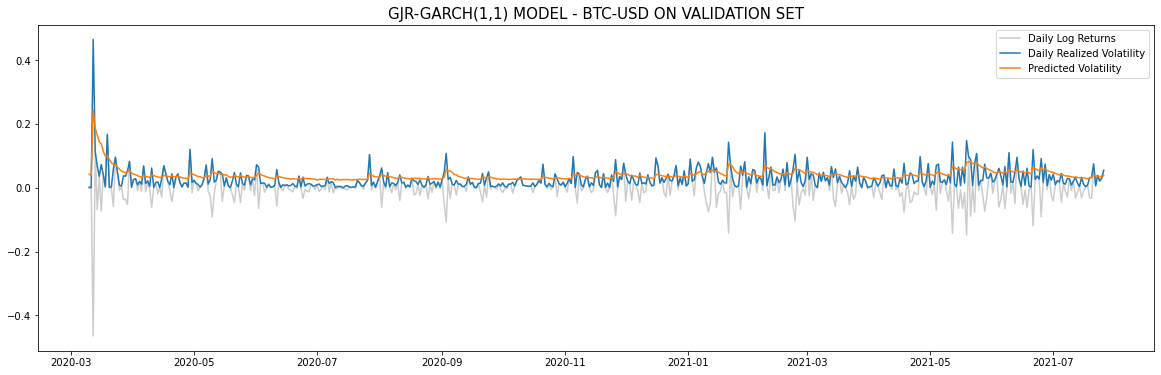

In [201]:
plt.figure(figsize=(20,6))
plt.plot(ts_val, color='gray', alpha=0.4, label='Daily Log Returns')

plt.plot(vol_val, label='Daily Realized Volatility')
plt.plot(rolling_predictions_2, label='Predicted Volatility')

plt.title(f'GJR-GARCH(1,1) MODEL - {tckr} ON VALIDATION SET', fontsize=15)
plt.legend();

In [211]:
RMSPE(vol_val, rolling_predictions_2)

80.46390202367687

In [212]:
RMSE(vol_val, rolling_predictions_2)

0.029361097682281727

### EGARCH

Exponential GARCH

In [214]:
e_gm = arch_model(ts_train, p=1, q=1, o=1, 
                    mean='Zero', vol='EGARCH')
result_3 = e_gm.fit(disp='off')
print()
print(result_3.summary())


                       Zero Mean - EGARCH Model Results                       
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:                3913.05
Distribution:                  Normal   AIC:                          -7818.10
Method:            Maximum Likelihood   BIC:                          -7795.69
                                        No. Observations:                 2000
Date:                Wed, Aug 11 2021   Df Residuals:                     2000
Time:                        03:43:57   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega         -0.4853      0.144     -3.361  7.775e-04

In [215]:
# EXPANDING WINDOW FORECAST
# INITIALIZING rolling_forecasts VALUES LIST
rolling_forecasts = []

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(ts_val)):
    # GET THE DATA AT ALL PREVIOUS TIME STEPS
    idx = val_idx[i]
    train = log_returns[:idx]

    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(train, p=1, q=1, o=1, 
                        mean='Zero', vol='EGARCH')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION
    pred = (model_fit.forecast(horizon=1, reindex=False).variance.values[0][0])**.5

    # APPEND TO rolling_forecasts LIST
    rolling_forecasts.append(pred)

In [216]:
rolling_predictions_3 = pd.Series(rolling_forecasts, index=ts_val.index)

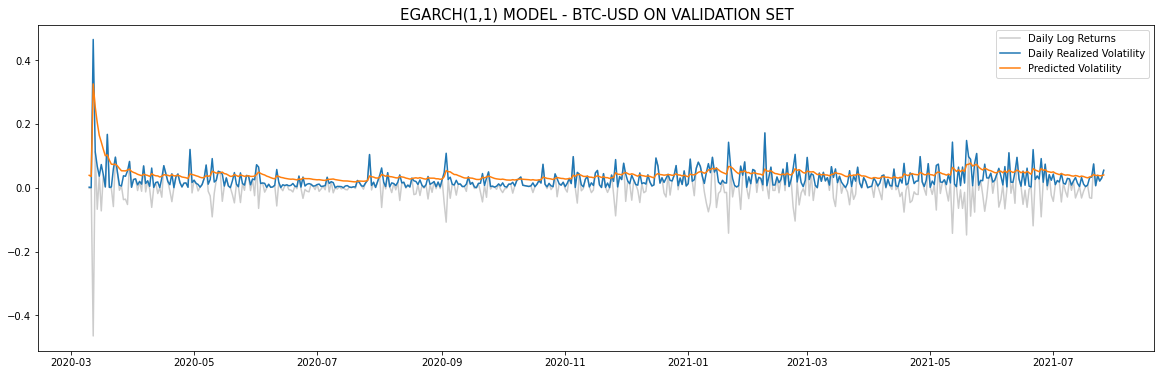

In [217]:
plt.figure(figsize=(20,6))
plt.plot(ts_val, color='gray', alpha=0.4, label='Daily Log Returns')

plt.plot(vol_val, label='Daily Realized Volatility')
plt.plot(rolling_predictions_3, label='Predicted Volatility')

plt.title(f'EGARCH(1,1) MODEL - {tckr} ON VALIDATION SET', fontsize=15)
plt.legend();

In [218]:
RMSPE(vol_val, rolling_predictions_3)

81.78425106984251

In [219]:
RMSE(vol_val, rolling_predictions_3)

0.02967190106841626

In [220]:
e_gm_t = arch_model(ts_train, p=1, q=1, o=1, 
                    mean='Zero', vol='EGARCH', dist='StudentsT')
result_4 = e_gm_t.fit(disp='off')
print()
print(result_4.summary())


                          Zero Mean - EGARCH Model Results                          
Dep. Variable:                        Close   R-squared:                       0.000
Mean Model:                       Zero Mean   Adj. R-squared:                  0.000
Vol Model:                           EGARCH   Log-Likelihood:                4193.61
Distribution:      Standardized Student's t   AIC:                          -8377.23
Method:                  Maximum Likelihood   BIC:                          -8349.22
                                              No. Observations:                 2000
Date:                      Wed, Aug 11 2021   Df Residuals:                     2000
Time:                              03:46:31   Df Model:                            0
                               Volatility Model                               
                  coef    std err          t      P>|t|       95.0% Conf. Int.
----------------------------------------------------------------------------

In [221]:
# ROLLING FORECAST
# INITIALIZING rolling_forecasts VALUES LIST
rolling_forecasts = []

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(ts_val)):
    # GET THE DATA AT ALL PREVIOUS TIME STEPS
    idx = val_idx[i]
    train = log_returns[:idx]

    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(train, p=1, q=1, o=1, 
                        mean='Zero', vol='EGARCH', dist='StudentsT')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION
    pred = (model_fit.forecast(horizon=1, reindex=False).variance.values[0][0])**.5

    # APPEND TO rolling_forecasts LIST
    rolling_forecasts.append(pred)

In [222]:
rolling_predictions_4 = pd.Series(rolling_forecasts, index=ts_val.index)

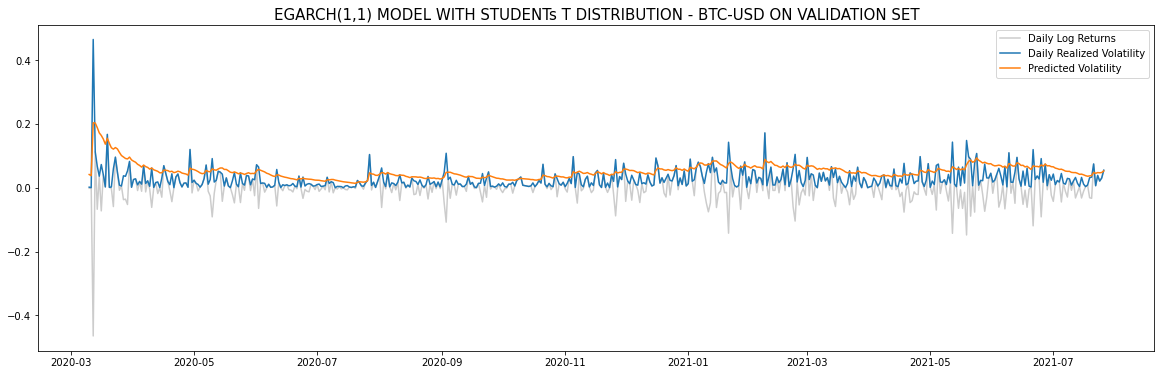

In [223]:
plt.figure(figsize=(20,6))
plt.plot(ts_val, color='gray', alpha=0.4, label='Daily Log Returns')

plt.plot(vol_val, label='Daily Realized Volatility')
plt.plot(rolling_predictions_4, label='Predicted Volatility')

plt.title(f'EGARCH(1,1) MODEL WITH STUDENTs T DISTRIBUTION - {tckr} ON VALIDATION SET', fontsize=15)
plt.legend();

In [224]:
RMSPE(vol_val, rolling_predictions_4)

104.40348233956882

### Vanilla LSTM

In [225]:
import tensorflow as tf

In [226]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

In [228]:
window_size = 14
batch_size = 32
shuffle_buffer_size = 1000

dataset = windowed_dataset(vol_train, window_size, batch_size, shuffle_buffer_size)

In [ ]:
lstm_1 = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
    tf.keras.layers.LSTM(28, activation='relu'),
    tf.keras.layers.Dense(1)
])

lstm_1.compile(optimizer='adam', loss='mse')
lstm_1.fit(dataset, epochs=100, batch_size=1, verbose=2)

In [236]:
forecast = []
idx = vols.index

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(vol_val)):
    # GET THE DATA AT THE PREVIOUS window_size TIME STEPS
    from_idx = idx[split_time_1 + i - window_size]
    to_idx = idx[split_time_1 + i - 1]
    pred = lstm_1.predict(vols[from_idx:to_idx].values[np.newaxis])
    forecast.append(pred)
    
forecast = np.array(forecast[-len(vol_val):])[:, 0, 0]

In [238]:
rolling_predictions_5 = pd.Series(forecast, index=ts_val.index)

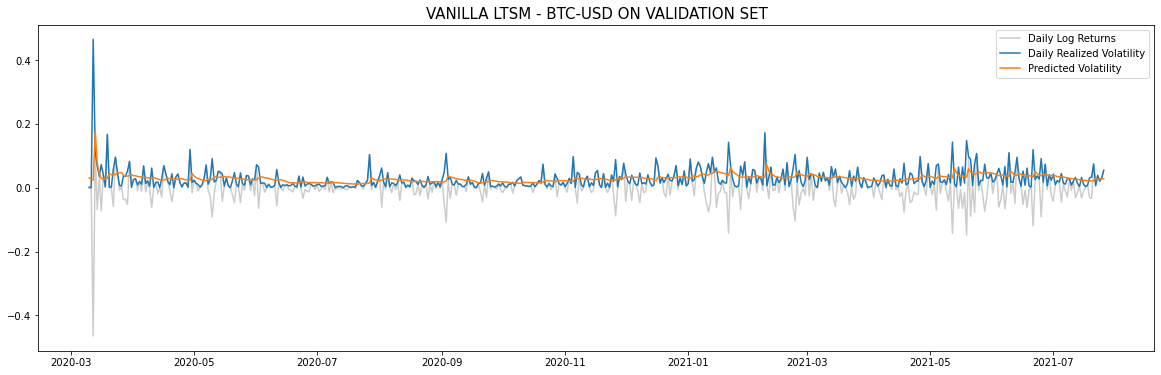

In [239]:
plt.figure(figsize=(20,6))
plt.plot(ts_val, color='gray', alpha=0.4, label='Daily Log Returns')

plt.plot(vol_val, label='Daily Realized Volatility')
plt.plot(rolling_predictions_5, label='Predicted Volatility')

plt.title(f'VANILLA LTSM - {tckr} ON VALIDATION SET', fontsize=15)
plt.legend();

In [240]:
RMSPE(vol_val, rolling_predictions_5)

64.12154412355942

In [248]:
RMSE(vol_val, rolling_predictions_5)

0.03395143928722226